In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import random
from types import SimpleNamespace
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import matplotlib.pyplot as plt

In [3]:
data_path="LEAD_DATASET/train.csv"

data_csv=pd.read_csv(data_path,low_memory=False)

In [4]:
data_csv.head()

,building_id,timestamp,meter_reading,anomaly
0,1,2016-01-01 00:00:00,NaN,0
1,32,2016-01-01 00:00:00,NaN,0
2,41,2016-01-01 00:00:00,NaN,0
3,55,2016-01-01 00:00:00,NaN,0
4,69,2016-01-01 00:00:00,NaN,0


In [5]:
data_csv.tail()

,building_id,timestamp,meter_reading,anomaly
1749489,1316,2016-12-31 23:00:00,38.844,0
1749490,1318,2016-12-31 23:00:00,202.893,0
1749491,1319,2016-12-31 23:00:00,NaN,0
1749492,1323,2016-12-31 23:00:00,172.000,0
1749493,1353,2016-12-31 23:00:00,2.400,0


In [6]:
b_id=1304

In [7]:
sample_df=data_csv[data_csv['building_id'] == b_id].copy()

In [8]:
sample_df.reset_index(drop=True,inplace=True)

In [9]:
sample_df

,building_id,timestamp,meter_reading,anomaly
0,1304,2016-01-01 00:00:00,269.984,0
1,1304,2016-01-01 01:00:00,270.834,0
2,1304,2016-01-01 02:00:00,282.987,0
3,1304,2016-01-01 03:00:00,287.950,0
4,1304,2016-01-01 04:00:00,305.913,0
...,...,...,...,...
8779,1304,2016-12-31 19:00:00,319.548,0
8780,1304,2016-12-31 20:00:00,310.931,0
8781,1304,2016-12-31 21:00:00,293.985,0
8782,1304,2016-12-31 22:00:00,331.945,0


In [10]:
SEQ_LEN=300

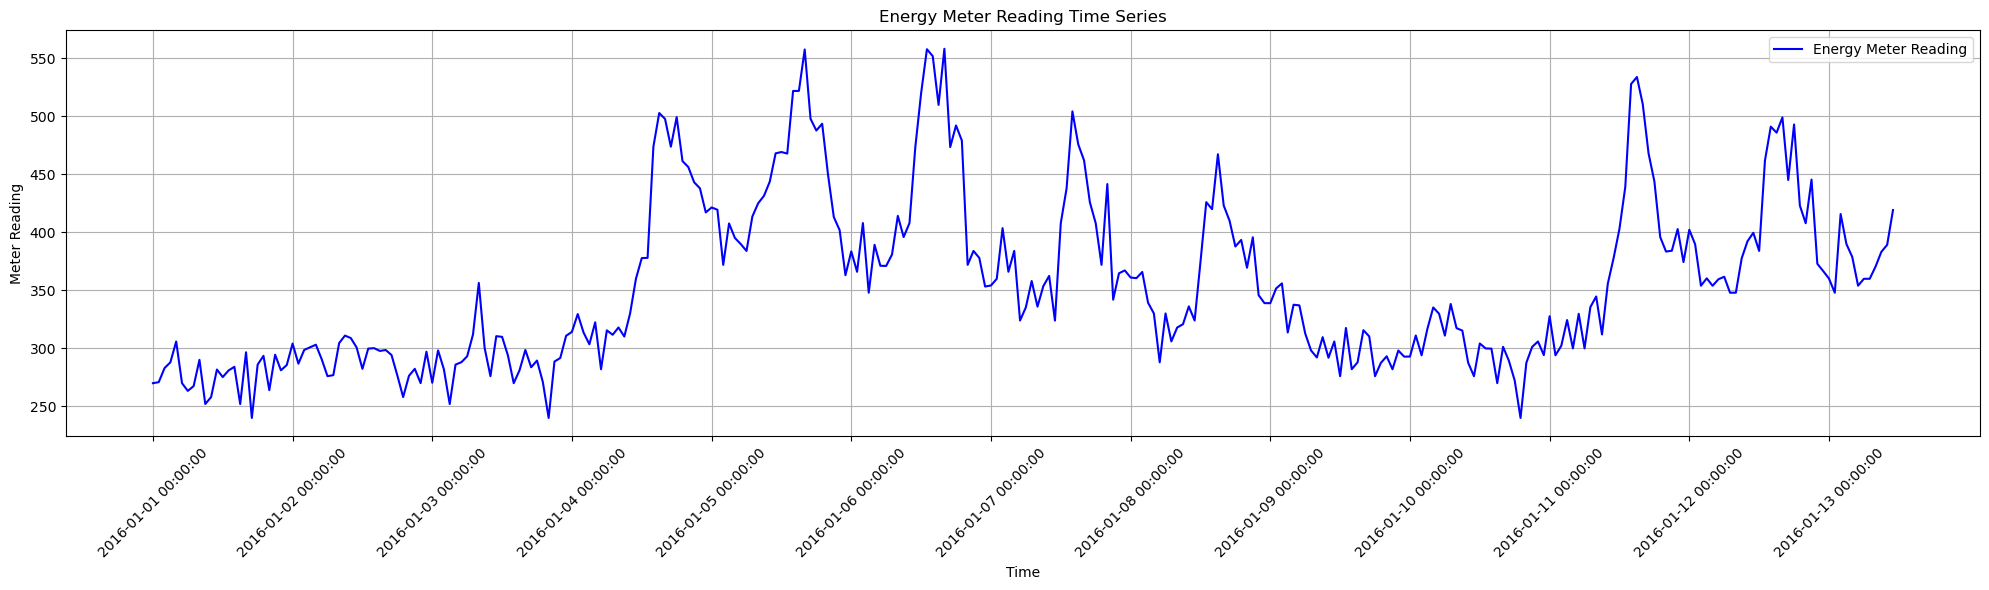

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(sample_df['timestamp'].values[:SEQ_LEN], sample_df['meter_reading'].values[:SEQ_LEN], color='blue', label='Energy Meter Reading')
plt.xlabel('Time')
plt.ylabel('Meter Reading')
plt.title('Energy Meter Reading Time Series')
plt.grid(True)
plt.legend()


all_ticks = sample_df['timestamp'].values[:SEQ_LEN]
selected_ticks = all_ticks[::24]
plt.xticks(selected_ticks, rotation=45)

plt.tight_layout()  

plt.show()

# Paper Implementation

In [12]:
def _generate_anomaly_indices_and_lengths(rng, series_len, count, length_params=None, existing_indices=None):
    if count == 0:
        return np.array([], dtype=int), np.array([], dtype=int)

    if existing_indices is None:
        existing_indices = set()

    lengths = []
    if length_params:
        # if length_params.get('distribution') == 'uniform':
        #     min_len = length_params['min']
        #     max_len = length_params['max']
        #     if min_len > max_len:
        #          warnings.warn(f"min_len ({min_len}) > max_len ({max_len}). Setting max_len = min_len.")
        #          max_len = min_len
        #     if min_len <= 0:
        #          warnings.warn(f"min_len ({min_len}) is <= 0. Setting min_len = 1.")
        #          min_len = 1
        #          if max_len < 1: max_len = 1 # Ensure max_len is also at least 1
        #     lengths = rng.integers(min_len, max_len + 1, size=count)
        # else:
        #     warnings.warn(f"Unsupported length distribution {length_params.get('distribution')}. Assuming length 1.")
        #     lengths = np.ones(count, dtype=int)

        min_samples=int(series_len*length_params['min']/100)
        max_samples=int(series_len*length_params['max']/100)
        total_samples=np.random.choice(range(min_samples,max_samples))
        print(total_samples)

        seq_min=2
        seq_max=5
        all_seq_lengths=[]
        while(total_samples>0):
            choice=np.random.choice(range(seq_min,seq_max+1))
            all_seq_lengths.append(choice)
            total_samples-=choice
        count=len(all_seq_lengths)
        
    else:
        lengths = np.ones(count, dtype=int)

    indices = []
    max_attempts = count * 10 # Try a reasonable number of times to find non-overlapping spots
    attempts = 0

    possible_start_indices = np.arange(series_len) # All possible indices initially
    #Change it to days instead use random indices - day of the year [ don't use initial zero values]
    
    while len(indices) < count and attempts < max_attempts:
        attempts += 1
        potential_length = all_seq_lengths[len(indices)] # Length for the current anomaly we try to place
        max_valid_start = series_len - potential_length

        if max_valid_start < 0: 
             warnings.warn(f"Anomaly length ({potential_length}) > series length ({series_len}). Cannot place.")
             continue 

        valid_start_indices = possible_start_indices[possible_start_indices <= max_valid_start]

        if len(valid_start_indices) == 0:
             break 

        potential_start = rng.choice(valid_start_indices)
        potential_end = potential_start + potential_length

        is_overlapping = False
        for idx in range(potential_start, potential_end):
            if idx in existing_indices:
                is_overlapping = True
                break

        if not is_overlapping:
            indices.append(potential_start)
            for idx in range(potential_start, potential_end):
                 existing_indices.add(idx)

    if len(indices) < count:
        warnings.warn(f"Could only place {len(indices)} out of {count} requested non-overlapping anomalies.")
        all_seq_lengths = all_seq_lengths[:len(indices)]

    return np.array(indices, dtype=int), np.array(all_seq_lengths, dtype=int)


In [13]:
def _apply_labels(labels, indices, lengths, label_value):
    """Applies labels to the specified ranges."""
    for i, start_idx in enumerate(indices):
        end_idx = start_idx + lengths[i]
        actual_end = min(end_idx, len(labels))
        labels[start_idx:actual_end] = label_value
    return labels

In [14]:
def _generate_power_anomaly_type1(p_current, labels_current, p_original, count, label, seed, length_params, anomaly_params, rng, existing_indices):
    """Applies Power Anomaly Type 1 based on Formula (2)."""
    if count == 0: return p_current, labels_current, existing_indices

    p_next = p_current.copy()
    labels_next = labels_current.copy()
    local_rng = np.random.default_rng(seed)

    min_len_orig = length_params.get('min', 2)
    length_params_mod = length_params.copy()
    length_params_mod['min'] = max(2, min_len_orig)
    if length_params_mod['min'] > length_params_mod['max']:
         length_params_mod['max'] = length_params_mod['min'] # Ensure min <= max


    indices, lengths = _generate_anomaly_indices_and_lengths(local_rng, len(p_next), count, length_params_mod, existing_indices)

    if len(indices) == 0: return p_current, labels_current, existing_indices # No anomalies placed

    k = anomaly_params.get('k', 0) # Get constant offset k

    # Pre-calculate cumulative sum of original power
    p_original_cumsum = np.cumsum(p_original)
    # Pad with 0 at the beginning for easier indexing sum(p_t) up to t=1 (index 0) is 0
    p_original_cumsum_padded = np.insert(p_original_cumsum, 0, 0)


    for i, start_idx in enumerate(indices):
        l = lengths[i]
        end_idx = start_idx + l

        # n = 0 (index start_idx)
        sum_before_i = p_original_cumsum_padded[start_idx] # Sum p_1 to p_{i-1}
        p_next[start_idx] = -1 * sum_before_i - k

        # 0 < n < l - 1 (indices start_idx + 1 to end_idx - 2)
        if l > 2:
            p_next[start_idx + 1 : end_idx - 1] = 0

        # n = l - 1 (index end_idx - 1)
        sum_before_end = p_original_cumsum_padded[end_idx] # Sum p_1 to p_{i+l-1}
        p_next[end_idx - 1] = sum_before_end + k


    labels_next = _apply_labels(labels_next, indices, lengths, label)
    return p_next, labels_next, existing_indices # Return updated existing_indices

In [15]:
def _generate_power_anomaly_type2(p_current, labels_current, count, label, seed, length_params, anomaly_params, rng, existing_indices):
    """Applies Power Anomaly Type 2 based on Formula (4)."""
    if count == 0: return p_current, labels_current, existing_indices

    target = p_current.copy()
    labels_next = labels_current.copy()
    local_rng = np.random.default_rng(seed)

    # Ensure minimum length is 2 as per formula description
    min_len_orig = length_params.get('min', 2)
    length_params_mod = length_params.copy()
    length_params_mod['min'] = max(2, min_len_orig)
    if length_params_mod['min'] > length_params_mod['max']:
         length_params_mod['max'] = length_params_mod['min'] # Ensure min <= max


    indices, lengths = _generate_anomaly_indices_and_lengths(local_rng, len(target), count, length_params_mod, existing_indices)
    print('indices= ',indices)
    print('lengths= ',lengths)
    if len(indices) == 0: return p_current, labels_current, existing_indices

    ### COPIED FROM THE REPOSITORY
    softstart=True
    for idx, length in zip(indices, lengths):
        print(f"Starting index={idx}, Length= {length}")
        if length <= 1:
            raise Exception("Type 2 power anomalies must be longer than 1.")
        else:
            if softstart:
                r = np.random.rand()
                if r>0.5:
                    r=r-0.5
                if r<=0.05:
                    r=0.06
                energy_consumed = target[idx:idx + length].sum()
                target[idx] = r * target[idx]
                target[idx + 1:idx + length - 1] = 0
                target[idx + length - 1] = energy_consumed - target[idx]
            else:
                energy_consumed = target[idx:idx + length].sum()
                target[idx:idx + length - 1] = 0
                target[idx + length - 1] = energy_consumed
    #ENDS HERE
    labels_next = _apply_labels(labels_next, indices, lengths, label)
    return target, labels_next, existing_indices,indices,lengths

In [16]:
def _generate_power_anomaly_type3(p_current, labels_current, p_original, count, label, seed, anomaly_params, rng, existing_indices):
    """Applies Power Anomaly Type 3 based on Formulas (7) and (8)."""
    if count == 0: return p_current, labels_current, existing_indices

    target = p_current.copy()
    labels_next = labels_current.copy()
    local_rng = np.random.default_rng(seed)

    # Length is always 1 for Type 3 power anomaly spike
    indices, lengths = _generate_anomaly_indices_and_lengths(local_rng, len(p_next), count, length_params=None, existing_indices=existing_indices)

    if len(indices) == 0: return p_current, labels_current, existing_indices

    is_extreme = anomaly_params.get('is_extreme', False)
    k = anomaly_params.get('k', 0) # Needed for extreme case
    range_r = anomaly_params.get('range_r', (0.61, 1.62)) # Default from paper Table 3 if not provide


    
    for idx, length in zip(indices, lengths):
        if length > 1:
            raise Exception("Type 3 power anomalies can't be longer than 1.")
        else:
            if is_extreme:
                energy_consumed = target[:idx].sum()
                target[idx] = -1 * energy_consumed - k
            else:
                r = np.random.uniform(*range_r)
                target[idx] = -1 * r * target[idx - 1]

    labels_next = _apply_labels(labels_next, indices, lengths, label) # Lengths are all 1
    return p_next, labels_next, existing_indices

In [17]:
def _generate_power_anomaly_type4(p_current, labels_current, count, label, seed, anomaly_params, rng, existing_indices):
    """Applies Power Anomaly Type 4 based on Formula (10)."""
    if count == 0: return p_current, labels_current, existing_indices

    p_next = p_current.copy()
    labels_next = labels_current.copy()
    local_rng = np.random.default_rng(seed)

    # Length is always 1 for Type 4 power anomaly spike
    indices, lengths = _generate_anomaly_indices_and_lengths(local_rng, len(p_next), count, length_params=None, existing_indices=existing_indices)

    if len(indices) == 0: return p_current, labels_current, existing_indices

    range_r = anomaly_params.get('range_r', (1.15, 13.0)) # Default from paper Table 3 (combining slight/extreme ranges)

    # Generate r values
    r_values = local_rng.uniform(range_r[0], range_r[1], size=len(indices))

    for i, start_idx in enumerate(indices):
        r = r_values[i]
        if start_idx == 0:
            # Handle edge case: No p_{i-1}. 
            p_prev = p_current[start_idx]
        else:
            p_prev = p_current[start_idx - 1] # Use value from previous step
        p_next[start_idx] = r * p_prev

    labels_next = _apply_labels(labels_next, indices, lengths, label) # Lengths are all 1
    return p_next, labels_next, existing_indices

In [18]:
def create_power_anomalies_from_paper(p, e, hparams,apply_rules=[1,2,3,4]):
    """
    Generates power anomalies based on formulas in Turowski et al. (2022).

    Args:
        p (np.ndarray): The input power time series.
        e (np.ndarray): The corresponding input energy time series (needed for k).
        hparams (SimpleNamespace or similar): Object containing hyperparameters.
                                             See original code/paper for attributes.

    Returns:
        tuple: (p_original, labels, p_anomalous)
    """
    p_original = np.asarray(p).copy()
    p_modified = p_original.copy()
    labels = np.zeros_like(p_modified, dtype=int)
    n = len(p_modified)
    master_rng = np.random.default_rng(hparams.seed)
    existing_indices = set() # Track indices covered by any anomaly

    # Determine k (constant offset) - using first energy value as proxy like in paper's evaluation section 4.2
    # Or default to 0 if energy series is not provided or empty
    k_offset = e[0] if e is not None and len(e) > 0 else 0
    if hasattr(hparams, 'k') and hparams.k is not None:
        k_offset = hparams.k # Allow overriding via hparams
    # print(f"Using k_offset = {k_offset} for power anomalies Type 1 & 3 (extreme)")


    # Apply in order: Type 1 -> Type 2 -> Type 3 -> Type 4

    # Type 1
    if 1 in apply_rules:
        p_modified, labels, existing_indices = _generate_power_anomaly_type1(
            p_modified, labels, p_original, hparams.type1, label=1, seed=hparams.seed + 1,
            length_params={'distribution': 'uniform', 'min': hparams.type1_len_min, 'max': hparams.type1_len_max},
            anomaly_params={'k': k_offset},
            rng=master_rng, existing_indices=existing_indices
        )
        print(f"Applied Power Type 1. Anomalous indices count: {len(existing_indices)}")
        print(np.max(p_modified))

    # Type 2
    if 2 in apply_rules:
        p_modified, labels, existing_indices,indices,lengths = _generate_power_anomaly_type2(
            p_modified, labels, hparams.type2, label=2, seed=hparams.seed + 2,
            length_params={'distribution': 'uniform', 'min': hparams.min_perc, 'max': hparams.max_perc},
            # Pass softstart if needed by internal logic, though formula uses r
            anomaly_params={'softstart': getattr(hparams, 'type2_softstart', False)},
            rng=master_rng, existing_indices=existing_indices
        )
        print(f"Applied Power Type 2. Anomalous indices count: {len(existing_indices)}")
        print(np.max(p_modified))


    # Type 3
    if 3 in apply_rules:
        
        type3_label = 31 # Default slight
        type3_params = {'is_extreme': False, 'range_r': (hparams.type3_r_min, hparams.type3_r_max)}
        type3_seed = hparams.seed + 3
        if getattr(hparams, 'type3_extreme', False):
            type3_label = 32 # Extreme
            type3_params = {'is_extreme': True, 'k': k_offset} # Use k for extreme
            type3_seed = hparams.seed + 4 # Use different seed for extreme as in original code
    
        p_modified, labels, existing_indices = _generate_power_anomaly_type3(
            p_modified, labels, p_original, hparams.type3, label=type3_label, seed=type3_seed,
            anomaly_params=type3_params,
            rng=master_rng, existing_indices=existing_indices
        )
        print(f"Applied Power Type 3. Anomalous indices count: {len(existing_indices)}")
        print(np.max(p_modified))


    # Type 4
    if 4 in apply_rules:
        
        p_modified, labels, existing_indices = _generate_power_anomaly_type4(
            p_modified, labels, hparams.type4, label=4, seed=hparams.seed + 5,
            anomaly_params={'range_r': (hparams.type4_r_min, hparams.type4_r_max)},
            rng=master_rng, existing_indices=existing_indices
        )
        print(f"Applied Power Type 4. Anomalous indices count: {len(existing_indices)}")
        print(np.max(p_modified))


    return p_original, labels, p_modified,indices,lengths


## Data Imputer

In [19]:
from sklearn.impute import SimpleImputer

In [20]:
def data_preprocess(sample_df):
    impute=SimpleImputer(strategy='median')

    sample_df.loc[sample_df.anomaly==1,'meter_reading']=sample_df['meter_reading'].median()
    imp_vals=impute.fit_transform(sample_df['meter_reading'].values.reshape(-1,1))
    original_anomalies=np.zeros_like(sample_df['anomaly'].values)
    return imp_vals,original_anomalies

In [34]:
def do_for_building(df,bid):
    sample_df=df[df['building_id']==bid].copy()
    imp_vals,labels_p=data_preprocess(sample_df)
    power_hparams = SimpleNamespace(
    seed=42,
    type2=100, min_perc=2, max_perc=5, type2_softstart=True,
    )
    original_p, labels_p, anomalous_p,indices,lengths= create_power_anomalies_from_paper(imp_vals, None, power_hparams,apply_rules=[2])
    all_ticks = sample_df['timestamp'].values
    mod_df=pd.DataFrame()
    mod_df['timestamp']=all_ticks
    mod_df['original']=original_p
    mod_df['modified']=anomalous_p
    mod_df['labels']=labels_p
    orig_mean,mod_mean,nums,min_len,max_len=mod_df['original'].mean(),mod_df['modified'].mean(),len(indices),min(lengths),max(lengths)
    all_anoms=mod_df[mod_df['labels']==2].sum()
    return orig_mean,mod_mean,nums,min_len,max_len,all_anoms
        

In [ ]:
# bids=[]
# orig_means=[]
# mod_means=[]
# all_nums=[]
# all_mins=[]
# all_maxs=[]
# total_anomalies=[]
# for bid in data_csv['building_id'].unique():
#     or_mean,m_mean,nu,mi,
    

In [21]:
imp_vals,labels_p=data_preprocess(sample_df)

## Apply to actual readings

In [22]:
power_hparams = SimpleNamespace(
    seed=42,
    type2=100, min_perc=2, max_perc=5, type2_softstart=True,
    type3=2, type3_extreme=False, type3_r_min=0.6, type3_r_max=1.6, # Based on paper Table 3/4 'slight'
    type4=4, type4_r_min=1, type4_r_max=2.0, # Based on paper Table 3/4 'slight'
)

In [23]:
print("--- Generating Power Anomalies ---")
original_p, labels_p, anomalous_p,indices,lengths= create_power_anomalies_from_paper(imp_vals, None, power_hparams,apply_rules=[2])

--- Generating Power Anomalies ---
Using k_offset = 0 for power anomalies Type 1 & 3 (extreme)
259
indices=  [5854 1076 7189 2265 5847 3562  776 8509 4694 1424 8727 7527  155 1431
  887 2967 3532 5951 6440 5412 3878 8383 3285 3610 3523 8249 8667 8134
 5148 6283  170 5192 7001  951 7909 4770 4600 7491 1731 8505 1587 6510
 7423 5731  765 6078 4794]
lengths=  [6 5 7 7 4 6 6 5 6 7 5 5 5 8 4 5 6 4 4 6 7 6 6 8 7 6 6 8 5 4 4 4 4 6 4 8 4
 6 4 4 6 4 4 7 5 4 7]
Starting index=5854, Length= 6
Starting index=1076, Length= 5
Starting index=7189, Length= 7
Starting index=2265, Length= 7
Starting index=5847, Length= 4
Starting index=3562, Length= 6
Starting index=776, Length= 6
Starting index=8509, Length= 5
Starting index=4694, Length= 6
Starting index=1424, Length= 7
Starting index=8727, Length= 5
Starting index=7527, Length= 5
Starting index=155, Length= 5
Starting index=1431, Length= 8
Starting index=887, Length= 4
Starting index=2967, Length= 5
Starting index=3532, Length= 6
Starting index=5951,

In [24]:
np.unique(labels_p,return_counts=True)

(array([0, 2]), array([8525,  259]))

In [25]:
print(f"\nPower Data Shape: {original_p.shape}")
print(f"Power Labels Shape: {labels_p.shape}")
print(f"Anomalous Power Shape: {anomalous_p.shape}")
print(f"Number of Power Anomalies (by label): {np.unique(labels_p, return_counts=True)}")


Power Data Shape: (8784, 1)
Power Labels Shape: (8784, 1)
Anomalous Power Shape: (8784, 1)
Number of Power Anomalies (by label): (array([0, 2]), array([8525,  259]))


In [26]:
np.max(original_p),np.min(original_p)

(np.float64(647.782), np.float64(173.982))

In [27]:
np.max(anomalous_p),np.min(anomalous_p)

(np.float64(2613.9591780567935), np.float64(0.0))

In [29]:
all_ticks = sample_df['timestamp'].values

In [30]:
# value_dict={'timestamp': all_ticks.flatten(),
#             'original': original_p.flatten(),
#             'modified': anomalous_p.flatten(),
#            'labels': labels_p.flatten()}
mod_df=pd.DataFrame()
mod_df['timestamp']=all_ticks
mod_df['original']=original_p
mod_df['modified']=anomalous_p
mod_df['labels']=labels_p
mod_df

,timestamp,original,modified,labels
0,2016-01-01 00:00:00,269.984,269.984,0
1,2016-01-01 01:00:00,270.834,270.834,0
2,2016-01-01 02:00:00,282.987,282.987,0
3,2016-01-01 03:00:00,287.950,287.950,0
4,2016-01-01 04:00:00,305.913,305.913,0
...,...,...,...,...
8779,2016-12-31 19:00:00,319.548,319.548,0
8780,2016-12-31 20:00:00,310.931,310.931,0
8781,2016-12-31 21:00:00,293.985,293.985,0
8782,2016-12-31 22:00:00,331.945,331.945,0


In [31]:
mod_df[mod_df['labels']==2]

,timestamp,original,modified,labels
155,2016-01-07 11:00:00,323.941,19.436460,2
156,2016-01-07 12:00:00,407.928,0.000000,2
157,2016-01-07 13:00:00,438.000,0.000000,2
158,2016-01-07 14:00:00,504.293,0.000000,2
159,2016-01-07 15:00:00,475.913,2130.638540,2
...,...,...,...,...
8727,2016-12-29 15:00:00,423.719,207.344484,2
8728,2016-12-29 16:00:00,360.043,0.000000,2
8729,2016-12-29 17:00:00,366.179,0.000000,2
8730,2016-12-29 18:00:00,384.016,0.000000,2


In [35]:
print(mod_df['original'].mean(),mod_df['modified'].mean(),len(indices),min(lengths),max(lengths))

311.2234231557377 311.2234231557377 47 4 8


In [36]:
max_e=int(np.max(anomalous_p))

In [37]:
all_ticks = sample_df['timestamp'].values

In [45]:
SEQ_LEN=100
START_INDEX=(3*30+3)*24+30
print(START_INDEX)

2262


In [46]:
selected_all_ticks=all_ticks[START_INDEX:START_INDEX+SEQ_LEN]
selected_original_p=original_p[START_INDEX:START_INDEX+SEQ_LEN]
selected_anomalous_p=anomalous_p[START_INDEX:START_INDEX+SEQ_LEN]
selected_labels_p=labels_p[START_INDEX:START_INDEX+SEQ_LEN]

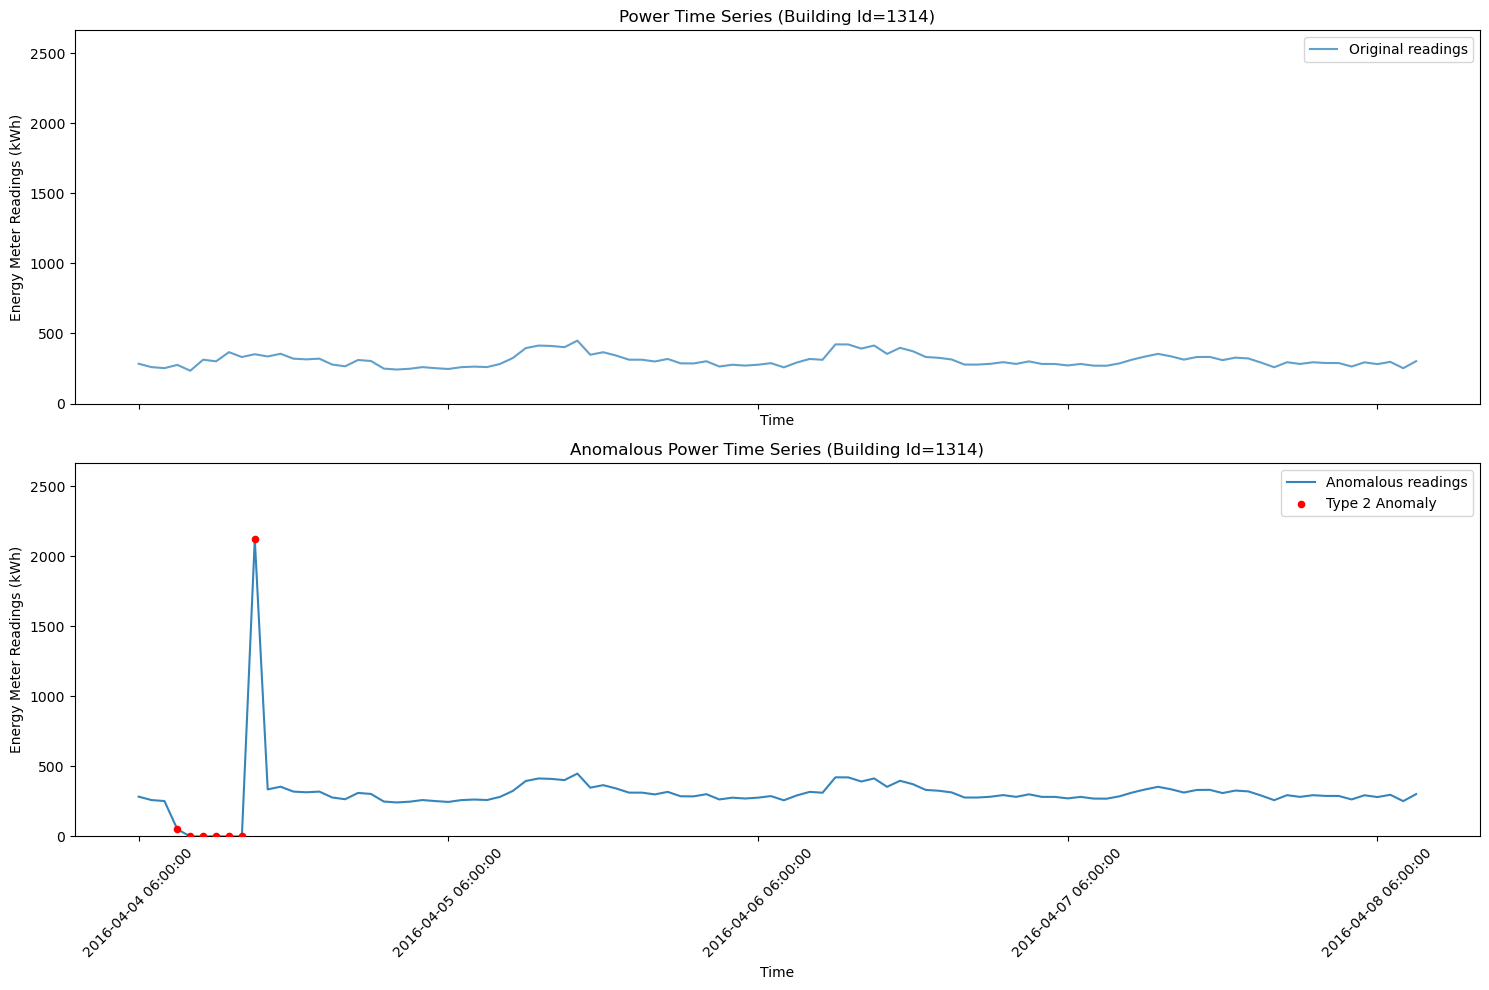

In [47]:

fig, axs = plt.subplots(2,1,figsize=(15, 10), sharex=True)

axs[0].plot(selected_all_ticks, selected_original_p, label='Original readings', alpha=0.7, zorder=1)
axs[1].plot(selected_all_ticks, selected_anomalous_p, label='Anomalous readings', alpha=0.9, zorder=2)
# Highlight anomalies
_type=2
selected_anomaly_indices_p = np.where(selected_labels_p == _type)[0]
if len(selected_anomaly_indices_p) > 0:
     axs[1].scatter(selected_all_ticks[selected_anomaly_indices_p], selected_anomalous_p[selected_anomaly_indices_p], color='red', s=20, label=f'Type {_type} Anomaly', zorder=3)
axs[0].set_title('Power Time Series (Building Id=1314)')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Energy Meter Readings (kWh)")
axs[0].grid(False)
axs[1].set_title('Anomalous Power Time Series (Building Id=1314)')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Energy Meter Readings (kWh)")
axs[1].grid(False)
new_ticks=selected_all_ticks[::24]
axs[0].set_ylim(0,max_e+50)
axs[1].set_ylim(0,max_e+50)
# axs.set_xticks(new_ticks,rotate=45)
plt.xticks(new_ticks, rotation=45)
axs[0].legend()
axs[1].legend()
plt.tight_layout()
fig.savefig('type_3_anomaly.png')

In [55]:
SEQ_LEN=100
START_INDEX=(3*30+3)*24+30+1000
print(START_INDEX)

3262


In [56]:
selected_all_ticks=all_ticks[START_INDEX:START_INDEX+SEQ_LEN]
selected_original_p=original_p[START_INDEX:START_INDEX+SEQ_LEN]
selected_anomalous_p=anomalous_p[START_INDEX:START_INDEX+SEQ_LEN]
selected_labels_p=labels_p[START_INDEX:START_INDEX+SEQ_LEN]

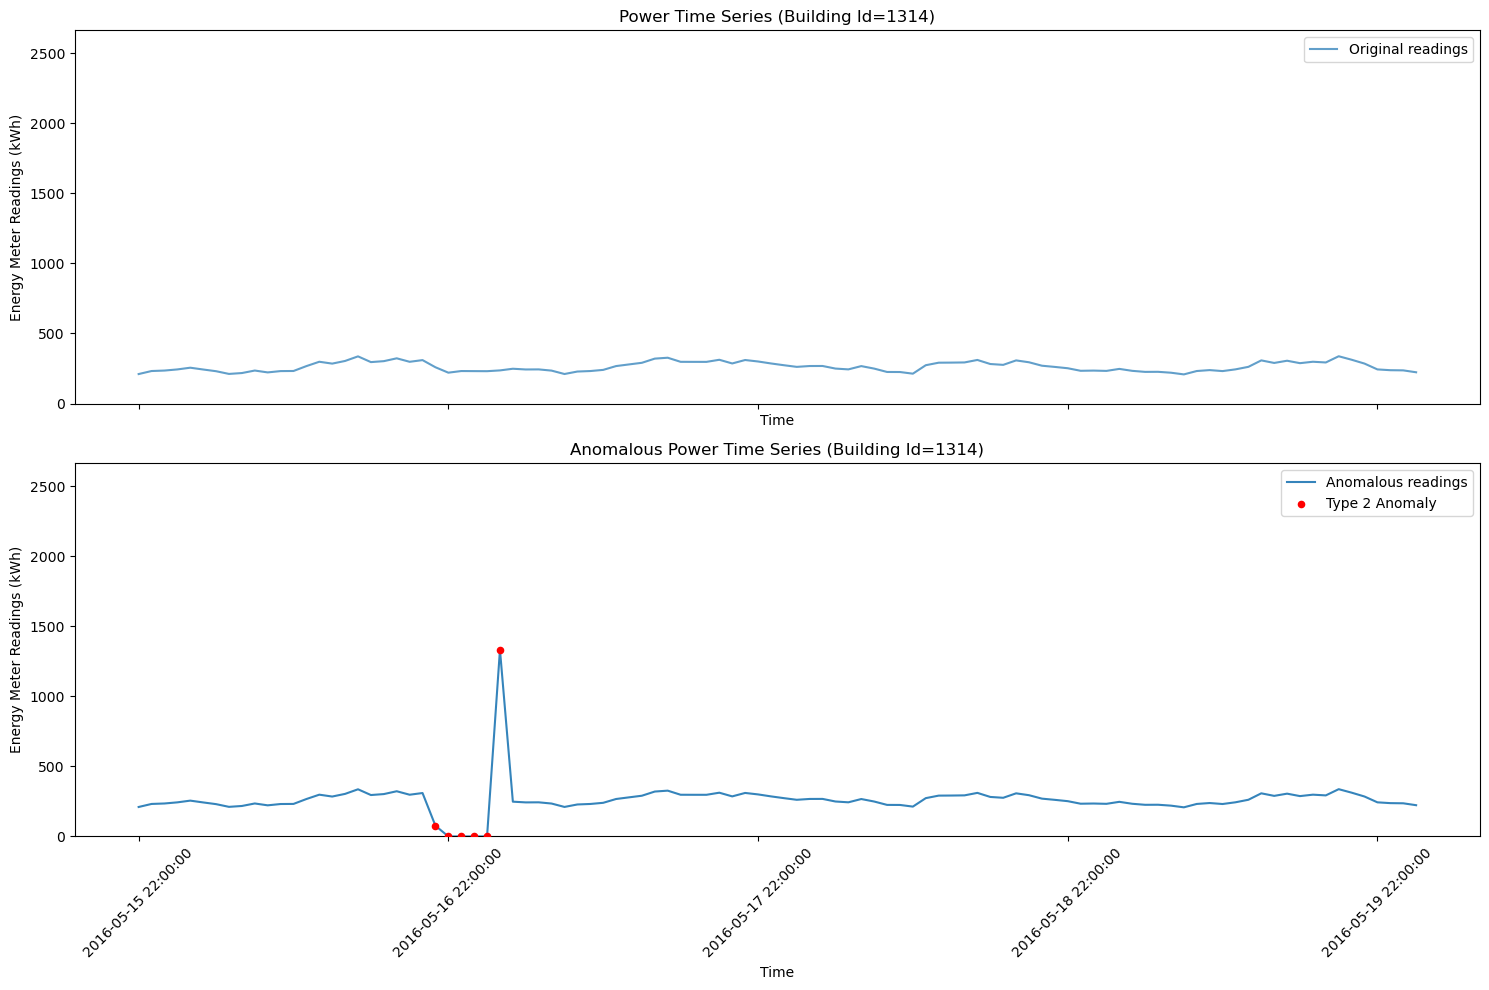

In [57]:

fig, axs = plt.subplots(2,1,figsize=(15, 10), sharex=True)

axs[0].plot(selected_all_ticks, selected_original_p, label='Original readings', alpha=0.7, zorder=1)
axs[1].plot(selected_all_ticks, selected_anomalous_p, label='Anomalous readings', alpha=0.9, zorder=2)
# Highlight anomalies
_type=2
selected_anomaly_indices_p = np.where(selected_labels_p == _type)[0]
if len(selected_anomaly_indices_p) > 0:
     axs[1].scatter(selected_all_ticks[selected_anomaly_indices_p], selected_anomalous_p[selected_anomaly_indices_p], color='red', s=20, label=f'Type {_type} Anomaly', zorder=3)
axs[0].set_title('Power Time Series (Building Id=1314)')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Energy Meter Readings (kWh)")
axs[0].grid(False)
axs[1].set_title('Anomalous Power Time Series (Building Id=1314)')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Energy Meter Readings (kWh)")
axs[1].grid(False)
new_ticks=selected_all_ticks[::24]
axs[0].set_ylim(0,max_e+50)
axs[1].set_ylim(0,max_e+50)
# axs.set_xticks(new_ticks,rotate=45)
plt.xticks(new_ticks, rotation=45)
axs[0].legend()
axs[1].legend()
plt.tight_layout()
fig.savefig('type_3_anomaly.png')

In [65]:
anom=(labels_p!=0).sum()
print(anom)

259


In [62]:
total_labels=len(labels_p)

In [67]:
print(total_labels)

8784


In [66]:
print(f"Percentage of anomalies: {anom/total_labels*100:.2f}%")

Percentage of anomalies: 2.95%


## Fraudlent Injection Data

In [ ]:
def get_beta_value(E, t):
    """Returns a sample beta value, assumed < 1 for attacks."""
    return 0.5 

In [ ]:

def partial_reduction_constant(U_E_t, alpha):
    if not (0 <= alpha < 1):
        raise ValueError("alpha must be less than 1 (and typically non-negative).")
    return alpha * U_E_t

In [ ]:

def partial_reduction_variable(U_E_t, beta_val):
    if not (0 <= beta_val < 1):
        raise ValueError("beta_val (representing β(E,t)) must be less than 1 (and typically non-negative).")
    return beta_val * U_E_t


In [ ]:
def selective_bypass(U_E_t, current_t, t_x, t_x_plus_n):
    if t_x <= current_t < t_x_plus_n:
        return 0.0
    else:
        return U_E_t


In [ ]:
def price_base_control_fixed_constant(E_n):
    return E_n


In [ ]:
def price_base_control_dynamic_variable(U_E_t, beta_val):
    if not (0 <= beta_val < 1):
        raise ValueError("beta_val (representing β(E,t)) must be a fraction < 1 (and typically non-negative).")
    return beta_val * U_E_t


In [ ]:
def price_base_control_shifted_reporting(data_series, current_time_index, T):
    shifted_index = current_time_index - T
    if 0 <= shifted_index < len(data_series):
        return data_series[shifted_index]
    else:
        # Returns np.nan if the shifted index is out of bounds
        return np.nan

In [ ]:
def price_base_control_swapping_extremes_frame(energy_frame):
    if not energy_frame or len(energy_frame) < 2:
        return list(energy_frame)

    frame_array = np.array(energy_frame)
    min_val, max_val = np.min(frame_array), np.max(frame_array)

    if min_val == max_val:
        return list(energy_frame)

    new_frame = frame_array.copy()
    min_indices, max_indices = np.where(frame_array == min_val)[0], np.where(frame_array == max_val)[0]

    for idx in min_indices: new_frame[idx] = max_val
    for idx in max_indices: new_frame[idx] = min_val
        
    return list(new_frame)

In [ ]:
df_original=new_df['original'].copy()

In [ ]:
df_original=pd.DataFrame(df_original)

In [ ]:
rng_global = np.random.default_rng(seed=42)
num_anomalies_to_generate = 3
anomaly_length_params = {'distribution': 'uniform', 'min': 5, 'max': 10}

In [ ]:
attacked_dfs=pd.DataFrame()

In [ ]:
# Attack f1: Partial Reduction Constant
df_attacked_f1 = df_original.copy()
alpha_f1 = 0.5 # Constant reduction factor
anomaly_starts_f1, anomaly_lengths_f1 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f1), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f1: {len(anomaly_starts_f1)} segments. Starts: {anomaly_starts_f1}, Lengths: {anomaly_lengths_f1}")
for start, length in zip(anomaly_starts_f1, anomaly_lengths_f1):
    for i in range(start, start + length):
        if i < len(df_attacked_f1):
            df_attacked_f1.loc[df_attacked_f1.index[i], 'original'] = partial_reduction_constant(
                df_attacked_f1.loc[df_attacked_f1.index[i], 'original'], alpha_f1
            )
attacked_dfs['partial_reduction_constant'] = df_attacked_f1

In [ ]:
# Attack f2: Partial Reduction Variable
df_attacked_f2 = df_original.copy()
anomaly_starts_f2, anomaly_lengths_f2 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f2), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f2: {len(anomaly_starts_f2)} segments. Starts: {anomaly_starts_f2}, Lengths: {anomaly_lengths_f2}")
for start, length in zip(anomaly_starts_f2, anomaly_lengths_f2):
    beta_val_segment_f2 = rng_global.uniform(0.2, 0.7) # Variable beta for this segment
    for i in range(start, start + length):
        if i < len(df_attacked_f2):
            df_attacked_f2.loc[df_attacked_f2.index[i], 'original'] = partial_reduction_variable(
                df_attacked_f2.loc[df_attacked_f2.index[i], 'original'], beta_val_segment_f2
            )
attacked_dfs['partial_reduction_variable'] = df_attacked_f2


In [ ]:
# Attack f3: Selective Bypass
df_attacked_f3 = df_original.copy()
anomaly_starts_f3, anomaly_lengths_f3 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f3), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f3: {len(anomaly_starts_f3)} segments. Starts: {anomaly_starts_f3}, Lengths: {anomaly_lengths_f3}")
for start, length in zip(anomaly_starts_f3, anomaly_lengths_f3):
    t_x = start # Start index of bypass
    t_x_plus_n = start + length # End index (exclusive) of bypass
    for i in range(start, start + length): # Iterate through current_t values in the segment
        if i < len(df_attacked_f3):
            df_attacked_f3.loc[df_attacked_f3.index[i], 'original'] = selective_bypass(
                df_attacked_f3.loc[df_attacked_f3.index[i], 'original'], 
                current_t=i, t_x=t_x, t_x_plus_n=t_x_plus_n 
            ) 
attacked_dfs['selective_bypass'] = df_attacked_f3

In [ ]:
# Attack f4: Price Base Control Fixed Constant
df_attacked_f4 = df_original.copy()
E_n_f4 = df_original['original'].mean() / 2.0 
anomaly_starts_f4, anomaly_lengths_f4 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f4), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f4: {len(anomaly_starts_f4)} segments. Starts: {anomaly_starts_f4}, Lengths: {anomaly_lengths_f4}")
for start, length in zip(anomaly_starts_f4, anomaly_lengths_f4):
    for i in range(start, start + length):
        if i < len(df_attacked_f4):
            df_attacked_f4.loc[df_attacked_f4.index[i], 'original'] = price_base_control_fixed_constant(E_n_f4)
attacked_dfs['price_base_control_fixed_constant'] = df_attacked_f4

In [ ]:
# Attack f5: Price Base Control Dynamic Variable
df_attacked_f5 = df_original.copy()
anomaly_starts_f5, anomaly_lengths_f5 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f5), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f5: {len(anomaly_starts_f5)} segments. Starts: {anomaly_starts_f5}, Lengths: {anomaly_lengths_f5}")
for start, length in zip(anomaly_starts_f5, anomaly_lengths_f5):
    beta_val_segment_f5 = rng_global.uniform(0.3, 0.8) # Variable beta for this segment
    for i in range(start, start + length):
        if i < len(df_attacked_f5):
            df_attacked_f5.loc[df_attacked_f5.index[i], 'original'] = price_base_control_dynamic_variable(
                df_attacked_f5.loc[df_attacked_f5.index[i], 'original'], beta_val_segment_f5
            )
attacked_dfs['price_base_control_dynamic_variable'] = df_attacked_f5

In [ ]:
# Attack f6: Price Base Control Shifted Reporting
df_attacked_f6 = df_original.copy()
T_shift_f6 = 2# Shift by 2 periods
original_series_for_f6 = df_original['original'].values 
anomaly_starts_f6, anomaly_lengths_f6 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f6), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f6: {len(anomaly_starts_f6)} segments. Starts: {anomaly_starts_f6}, Lengths: {anomaly_lengths_f6}")
for start, length in zip(anomaly_starts_f6, anomaly_lengths_f6):
    for i in range(start, start + length): # i is current_time_index
        if i < len(df_attacked_f6):
            shifted_value = price_base_control_shifted_reporting(
                original_series_for_f6, i, T_shift_f6
            )
            if not pd.isna(shifted_value):
                df_attacked_f6.loc[df_attacked_f6.index[i], 'original'] = shifted_value
attacked_dfs['price_base_control_shifted_reporting'] = df_attacked_f6

In [ ]:
# Attack f7: Price Base Control Swapping Extremes Frame
df_attacked_f7 = df_original.copy()
anomaly_starts_f7, anomaly_lengths_f7 = _generate_anomaly_indices_and_lengths(
    rng_global, len(df_attacked_f7), num_anomalies_to_generate, anomaly_length_params, set()
)
print(f"Applying f7: {len(anomaly_starts_f7)} segments. Starts: {anomaly_starts_f7}, Lengths: {anomaly_lengths_f7}")
for start, length in zip(anomaly_starts_f7, anomaly_lengths_f7):
    if length < 2: # Swapping needs at least 2 elements
        continue
    segment_indices = df_attacked_f7.index[start : start + length]
    current_frame_values = df_attacked_f7.loc[segment_indices, 'original'].tolist()
    
    swapped_frame_values = price_base_control_swapping_extremes_frame(current_frame_values)
    
    df_attacked_f7.loc[segment_indices, 'original'] = swapped_frame_values
attacked_dfs['price_base_control_swapping_extremes_frame'] = df_attacked_f7

In [ ]:
attacked_dfs